In [1]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io
from PIL import Image
import cv2
import imutils
from scipy.spatial import distance as dist

my_data = "/home/keeganfl/Desktop/Math_612_project/05-10-2015/Height/"
save_path = "/home/keeganfl/Desktop/Math_612_project/05-10-2015/cellpose_height/"

## Step 3:
Loading up the data from a specific cellpose run

In [2]:
dat = np.load(save_path + '10061218_height_seg.npy', allow_pickle=True).item()

# Create a list that contains each outline
outl = utils.outlines_list(dat['masks'])

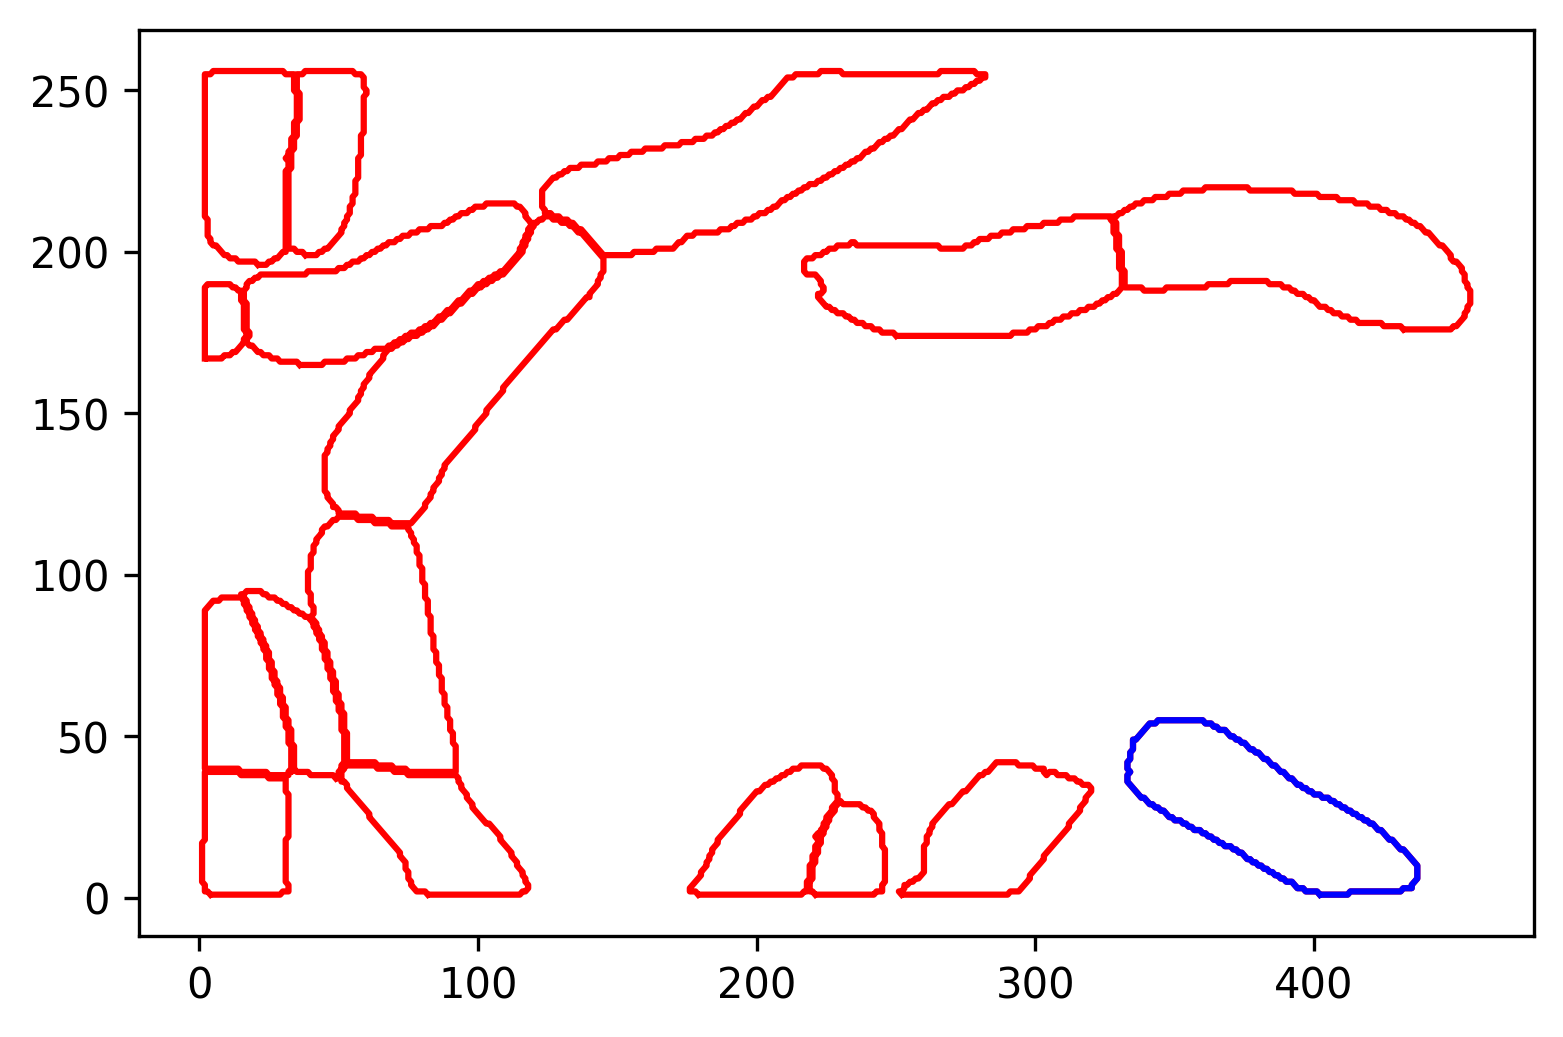

In [3]:
#plot just the outlines. I mostly use this to get a sense for each outline. 
for o in outl:
    plt.plot(o[:,0], o[:,1], color='r')
plt.plot(outl[5][:,0], outl[5][:,1], color = 'blue')

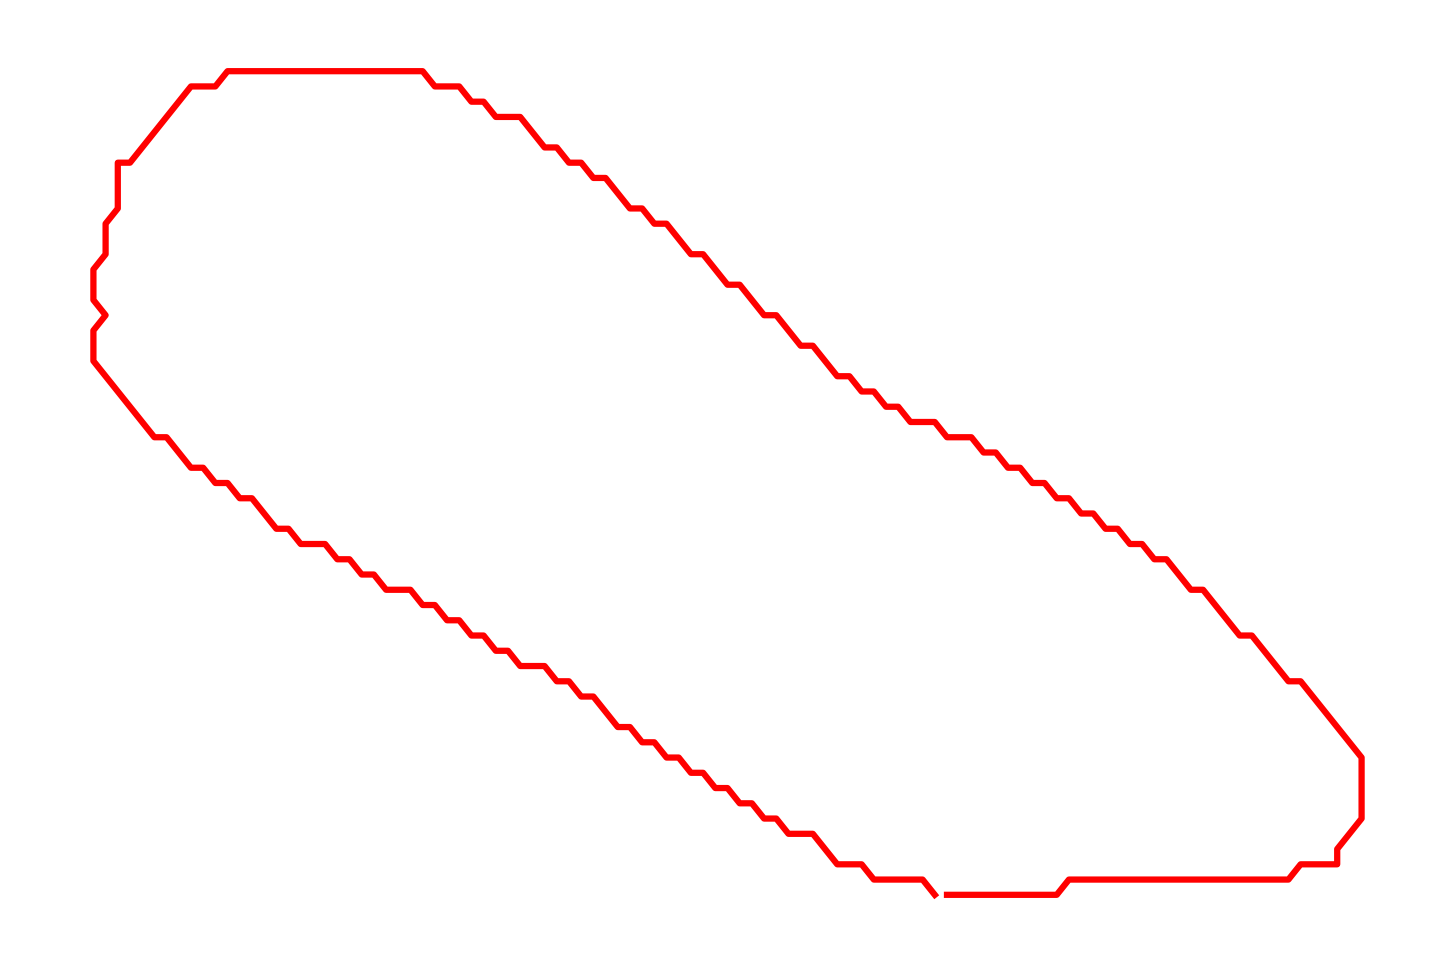

In [4]:
# plot an individual cell of choice. 
plt.plot(outl[5][:,0], outl[5][:,1], color = "r")
plt.axis("off")
plt.savefig("test.png")

## Save individual masks as png files

In [5]:
masks = dat["masks"]

img = dat["img"]
ls_outlines = utils.outlines_list(masks)

for idx, cell in enumerate(ls_outlines[:]):
    # mask outline
    mask = np.zeros(img.shape[0:2], dtype=np.uint8)
    channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
    ignore_mask_color = (255,)*channel_count
    cv2.fillPoly(mask, [cell], ignore_mask_color)
    
    # crop the cell
    x = cell.flatten()[::2]
    y = cell.flatten()[1::2]

    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))
    out = mask[topy:bottomy+1, topx:bottomx+1]
    
    #cv2.imwrite(os.path.join(name, str(idx) + ".png" ), out)
    im = Image.fromarray(out)
    im.save("Individual_masks/" + str(idx) + ".png")

## Look at an individual mask

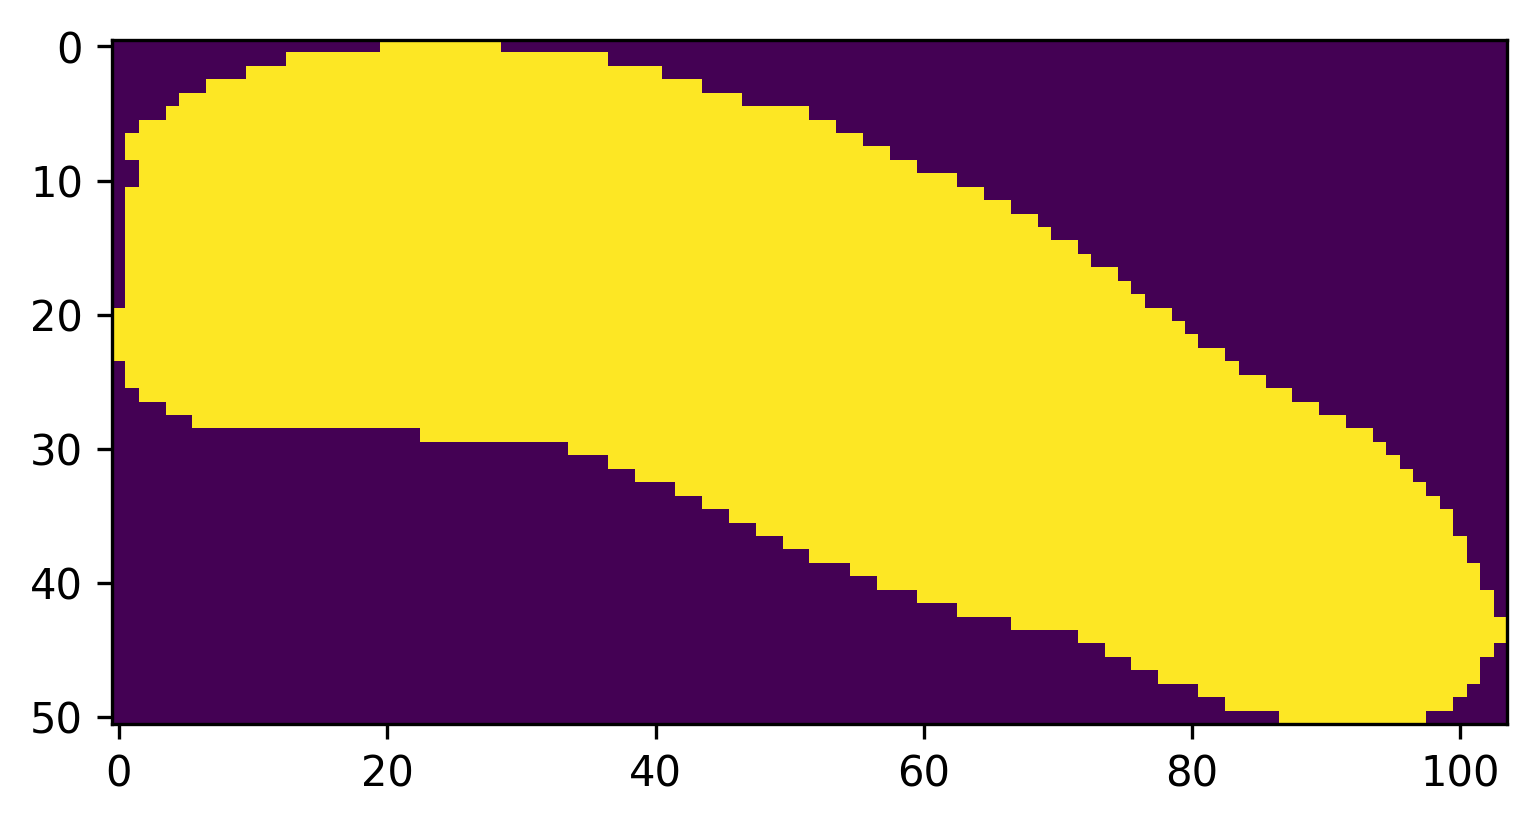

In [6]:
cell = outl[10]
# mask outline
mask = np.zeros(img.shape[0:2], dtype=np.uint8)
cv2.fillPoly(mask, [cell], color = (255,255,255))
    
# crop the cell
x = cell.flatten()[::2]
y = cell.flatten()[1::2]

(topy, topx) = (np.min(y), np.min(x))
(bottomy, bottomx) = (np.max(y), np.max(x))
out = mask[topy:bottomy+1, topx:bottomx+1]

plt.imshow(out)

# Finding the centers 

In [7]:
# define the image from the data.
img = dat["img"]

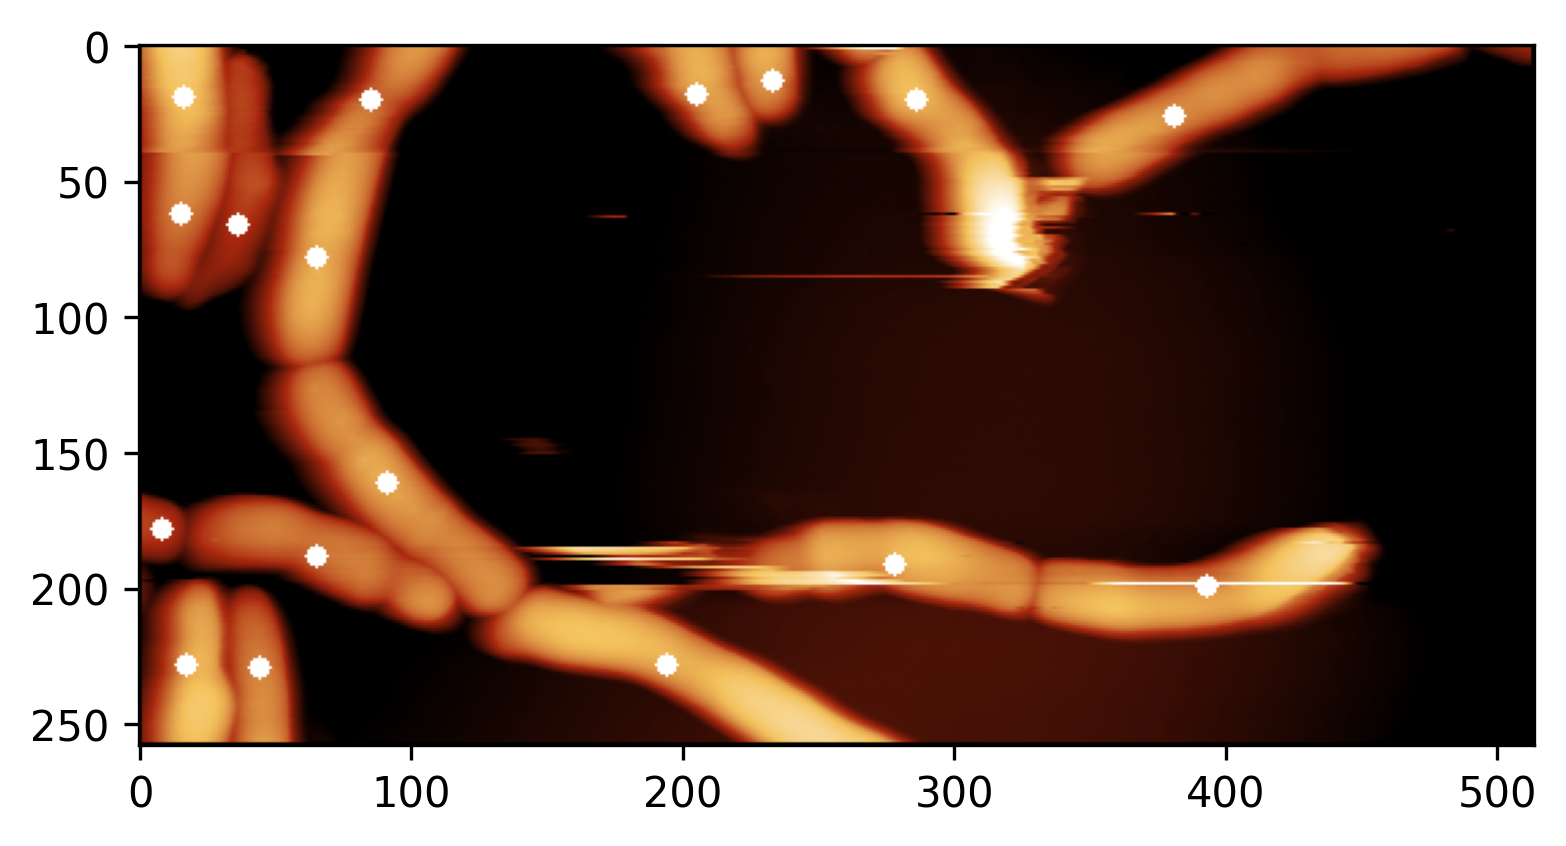

In [8]:
# loop over the contours and define each center.
centers = []
for c in outl:
    # compute the center of the contour
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    centers.append([cX, cY])
    # draw the contour and center of the shape on the image
    cv2.circle(img, (cX, cY), 4, (255, 255, 255), -1)
# show the image
plt.imshow(img)
centers = np.array(centers)
# Alright, so these cX and cYs contain all of the information I need on the center of the images. 

## Using Utils
useful utils may include:
- fill_holes_and_remove_small_masks
- get_mask_compactness
- get_mask_stats
- distance_to_boundary. This determines the distance of each pixel in a mask to the boundaries (I think). If I find the max of this it might help me find a center, although the rod shape may screw with that. 
- radius distribution 
- metrics 
- remove_edge_masks. This removes any mask that has a pixel on the edge of the image, might be helpful when cleaning up images. Would have to be careful not to screw with the metadata. Hmm, this does not work so good

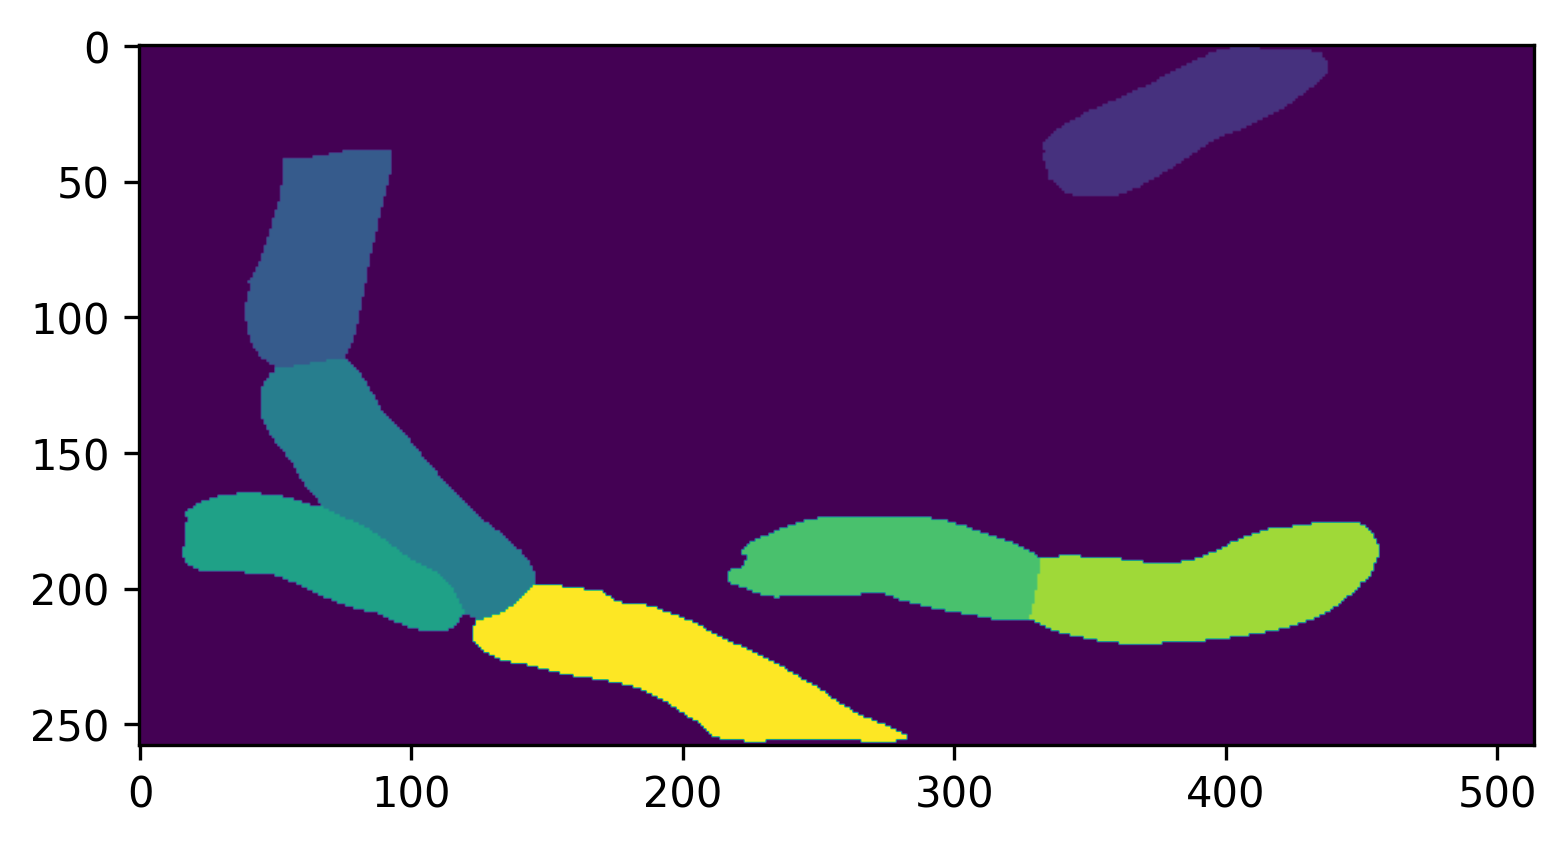

In [9]:
# Ok, I need to go hard to make this work.
###!!!### Also, I still do not understand why remove edge masks does not function. 
plt.imshow(utils.fill_holes_and_remove_small_masks(dat['masks'], min_size = 2000))

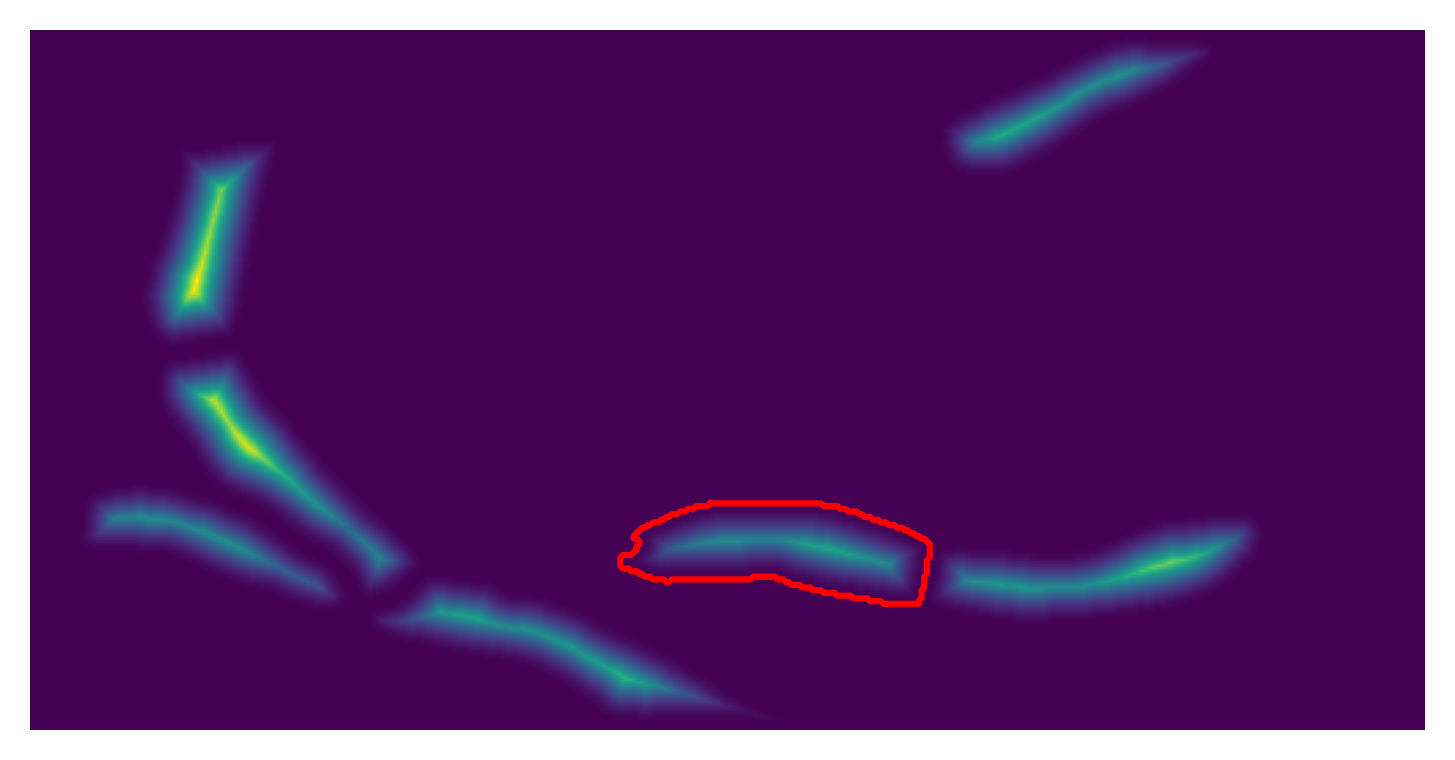

In [10]:
plt.imshow(utils.distance_to_boundary(dat['masks']))
# plot an individual cell of choice. 
plt.plot(outl[12][:,0], outl[12][:,1], color = "r")
plt.axis("off")
plt.savefig("test.png")

# Goals:
- Find center of all contours. Completed!!!
- Calculate if contours are touching each other and how much overlap there is. 
- Tell how distant the cell was from other contours in general? 
- Where was the cell in the overall image. 
- What was the time point of this image. Can calculate based on image name? 
- Use optical flow to track cell movement on a basic level. 
- Find a way to auto filter those weird looking cells. 
- What am I going to do when the pngs seem to change size randomly? Will any tracking I implement be able to cope? 
- How do I determine if cells are dividing vs being smushed together? Need the help of the actual data points? only bacteria connected pole to pole are touching? Take into account the time tracking? Maybe it should have an event for when a new cell appears. 

### determining overlap

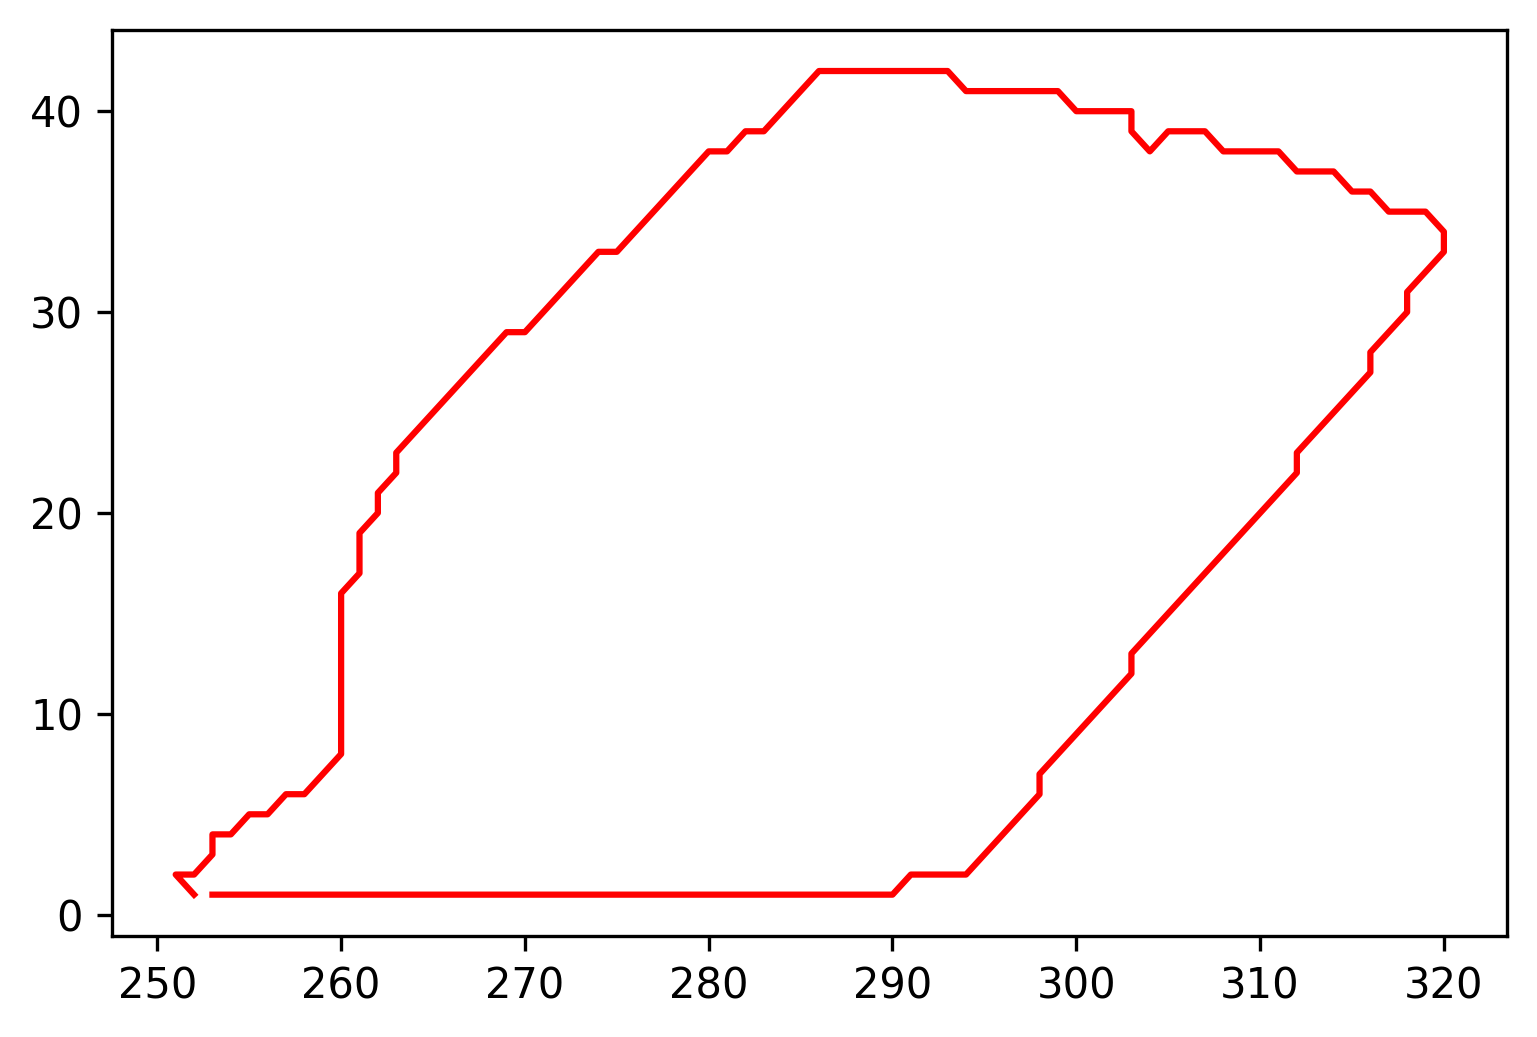

In [11]:
# plot the two cells where I want to determine touching surfaces. 
plt.plot(outl[4][:,0], outl[4][:,1], color = "r")
#plt.plot(outl[2][:,0], outl[2][:,1], color = "r")
#plt.xlim((310,400))

In [12]:
# An earlier version that just draws the lines for educative purposes. 
for out_cell, cen_cell in zip(outl, centers):
    for cen_oth in centers:
        distance = dist.euclidean(cen_cell,cen_oth)
        if distance > 150 or distance == 0:
            continue
        cv2.line(img, (int(cen_cell[0]),int(cen_cell[1])), (int(cen_oth[0]),int(cen_oth[1])), color = (0, 0, 255))

In [13]:
# hmmmm, this takes like, 10 seconds to run, and for an image of this size that is pretty pathetic... 
cell_overlaps = []
for out_cell, cen_cell in zip(outl, centers):
    adj = 0
    for out_oth, cen_oth in zip(outl, centers):
        cent_dist = dist.euclidean(cen_cell,cen_oth)
        if cent_dist > 150 or cent_dist == 0:
            continue
        for pixel1 in out_cell:
            for pixel2 in out_oth:
                distx = np.abs(pixel1[0]-pixel2[0])
                disty = np.abs(pixel1[1]-pixel2[1])
                if distx + disty == 1:
                    adj = adj + 1
    cell_overlaps.append(adj)

# I think the box idea in here is very good, but for now I can keep going with the slow version. 
Alright, this worked really well but it is pretty damn slow considering the task at hand. I think I can get away with a certain lack of speed at the moment. Perhaps a faster way to do this would be to draw those boxes around each of the cells and if those boxes intersect, then I will do the pixel algorithm.

Another poosibility would be to literally just enlarge the outline in every direction and detect intersection that way.

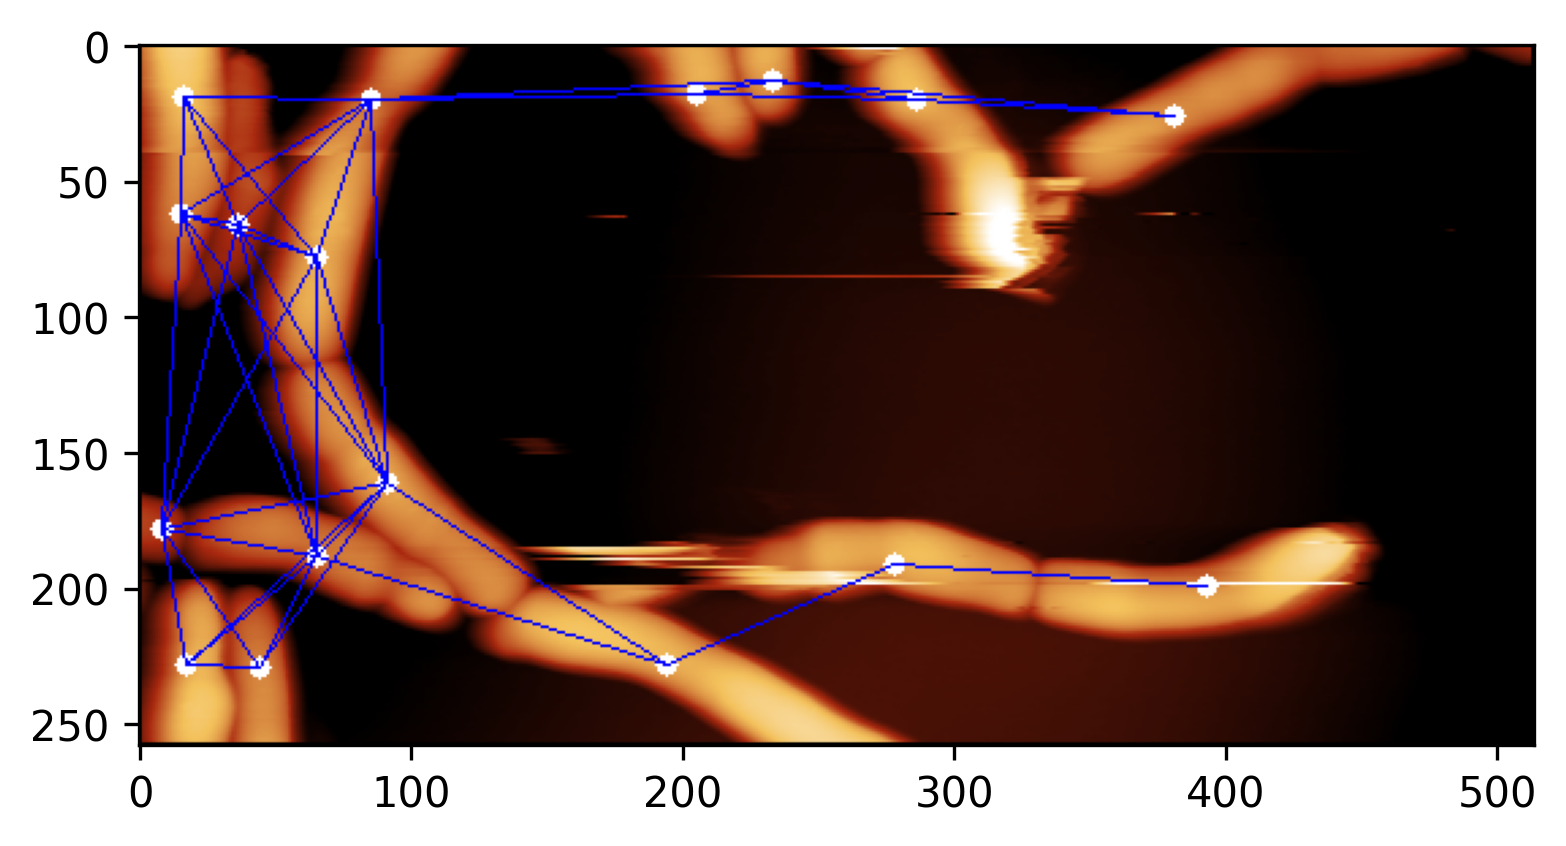

In [14]:
plt.imshow(img)

### For now, how about I set the cuttoff at 150 pixels. 

In [15]:
#OH SWEET GOD IN HEAVEN IT ACTUALLY KIND OF WORKED

Ok, so maybe I need to come at this on a pixel by pixel basis. Take each pixel, and have it scan all of the pixels that are 2 adjacent pixels away or more. If it finds even one that belongs to an different contour, then that pixel counts as a single "connected" pixel. this connectedness is added to a table with the metadata for each cell. 

Maybe an even better idea is to just measure closeness. Like, I take every pixel in a cell, and I measure its minimum distance to something else. If that minimum distance is 1 it is adjacent. If it is not 1 then they are not adjacent. 

Maybe simplify it all the way down to just finding adjacent pairs in the arrays? Like, it just looks through the arrays to find the nearly matching points? If I really do something like this, I would need somekind of filtering parameter, like only do this on cells that are at least this close based on a basic comparison on centroid distance. 

# Note too self:
If I can make a set of images that is literally just centroids that would be very helpful. 

# Putting it all together. 

I want to start creating a table where, for each cell, we have the perimeter, the area, the amount of overlap, the position of the center, 

In [16]:
#!!### I think this will actually be useful for the metadata. 
perimeters = utils.get_mask_perimeters(dat['masks'])

In [17]:
print(centers)
print(cell_overlaps)
print(perimeters)


[[ 16  19]
 [ 85  20]
 [205  18]
 [233  13]
 [286  20]
 [381  26]
 [ 36  66]
 [ 15  62]
 [ 65  78]
 [ 91 161]
 [ 65 188]
 [  8 178]
 [278 191]
 [393 199]
 [ 17 228]
 [ 44 229]
 [194 228]]
[32, 50, 39, 39, 0, 0, 142, 108, 131, 157, 113, 20, 27, 27, 59, 59, 35]
[262.93607486 237.88225099 305.06096654 261.13708499 278.36753237
 311.92388155 370.1492783 ]
